In [18]:
from dataclasses import dataclass, asdict
from copy import deepcopy
from typing import Any, Callable
from __future__ import annotations
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib


In [2]:
np.random.seed(42)

setting = {
    "style": "white",
    "palette": "deep",
    "font": "IPAexGothic",
    "rc": {
        "figure.dpi": 300,
        "figure.figsize": (6, 4),
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": ".8",
        "grid.linewidth": 0.5,
        "grid.linestyle": "dotted",
        "axes.edgecolor": ".3",
        "axes.labelcolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "figure.constrained_layout.use": True,
    },
}
sns.set(**setting)

warnings.simplefilter("ignore")

In [37]:
@dataclass
class Simulator:
    n_simulations: int
    n_samples: int
    n_features: int
    rho: float
    sigma_e: float

    def generate_simulation_data(
        self,
        n_simulations: int,
        n_samples: int,
        n_features: int,
        rho: float,
        sigma_e: float,
    ) -> tuple(np.ndarray, np.ndarray):
        """"""

        # シミュレーションの設定
        # X0とX1のみ相関がありうる設定にする
        mean = np.zeros(n_features)
        cov = np.eye(n_features)
        cov[0, 1] = cov[1, 0] = rho

        # 特徴量とノイズを生成
        X = np.random.multivariate_normal(mean, cov, size=(n_simulations, n_samples))
        e = np.random.normal(0, sigma_e, size=(n_simulations, n_samples))

        # 係数はすべて1なので、単に和をとる
        y = X.sum(axis=2) + e

        return (X, y)

    def estimate(self, X: np.ndarray, y: np.ndarray, l2_lambda: float) -> np.ndarray:
        """"""

        XT = np.transpose(X, axes=(0, 2, 1))
        Y = y.reshape((-1, self.n_samples, 1))

        I = np.row_stack([np.eye(self.n_features)] * self.n_simulations)
        I = I.reshape(self.n_simulations, self.n_features, self.n_features)

        hbeta = np.linalg.inv(XT @ X + l2_lambda * I) @ (XT @ Y)

        return hbeta.reshape(-1, self.n_features)

    def calc_mean_se(
        self, hbeta: np.ndarray, target_key: str, target_values: list
    ) -> pd.DataFrame:
        """"""

        df = pd.DataFrame({target_key: target_values})
        df[[f"Mean{j}" for j in range(self.n_features)]] = hbeta.mean(axis=1)
        df[[f"SE{j}" for j in range(self.n_features)]] = hbeta.std(axis=1)

        return df

    def simulate(
        self, target_key: str, target_values: list, l2_lambda: float = 0
    ) -> pd.DataFrame:
        """"""

        hbeta = np.zeros((len(target_values), self.n_simulations, self.n_features))

        params = dataclasses.asdict(self)
        for i, target_value in enumerate(target_values):
            params.update({target_key: target_value})
            X, y = self.generate_simulation_data(**params)
            hbeta[i, :, :] = self.estimate(X, y, l2_lambda)

        return self.calc_mean_se(hbeta, target_key, target_values)

    def plot(self, df: pd.DataFrame, target_key: str, kind: str) -> None:
        """"""
        fig, ax = plt.subplots()

        for j in range(self.n_features):
            ax.plot(df[target_key], df[f"{kind}{j}"], label=f"beta{j}")
        ax.legend()
        ax.set(xlabel=target_key, ylabel=kind)
        fig.suptitle(f"{target_key}と回帰係数の{kind}の関係")
        fig.show()

In [38]:
base_params = {
    "n_simulations": 2000,
    "n_samples": 100,
    "n_features": 3,
    "rho": 0,
    "sigma_e": 5,
}

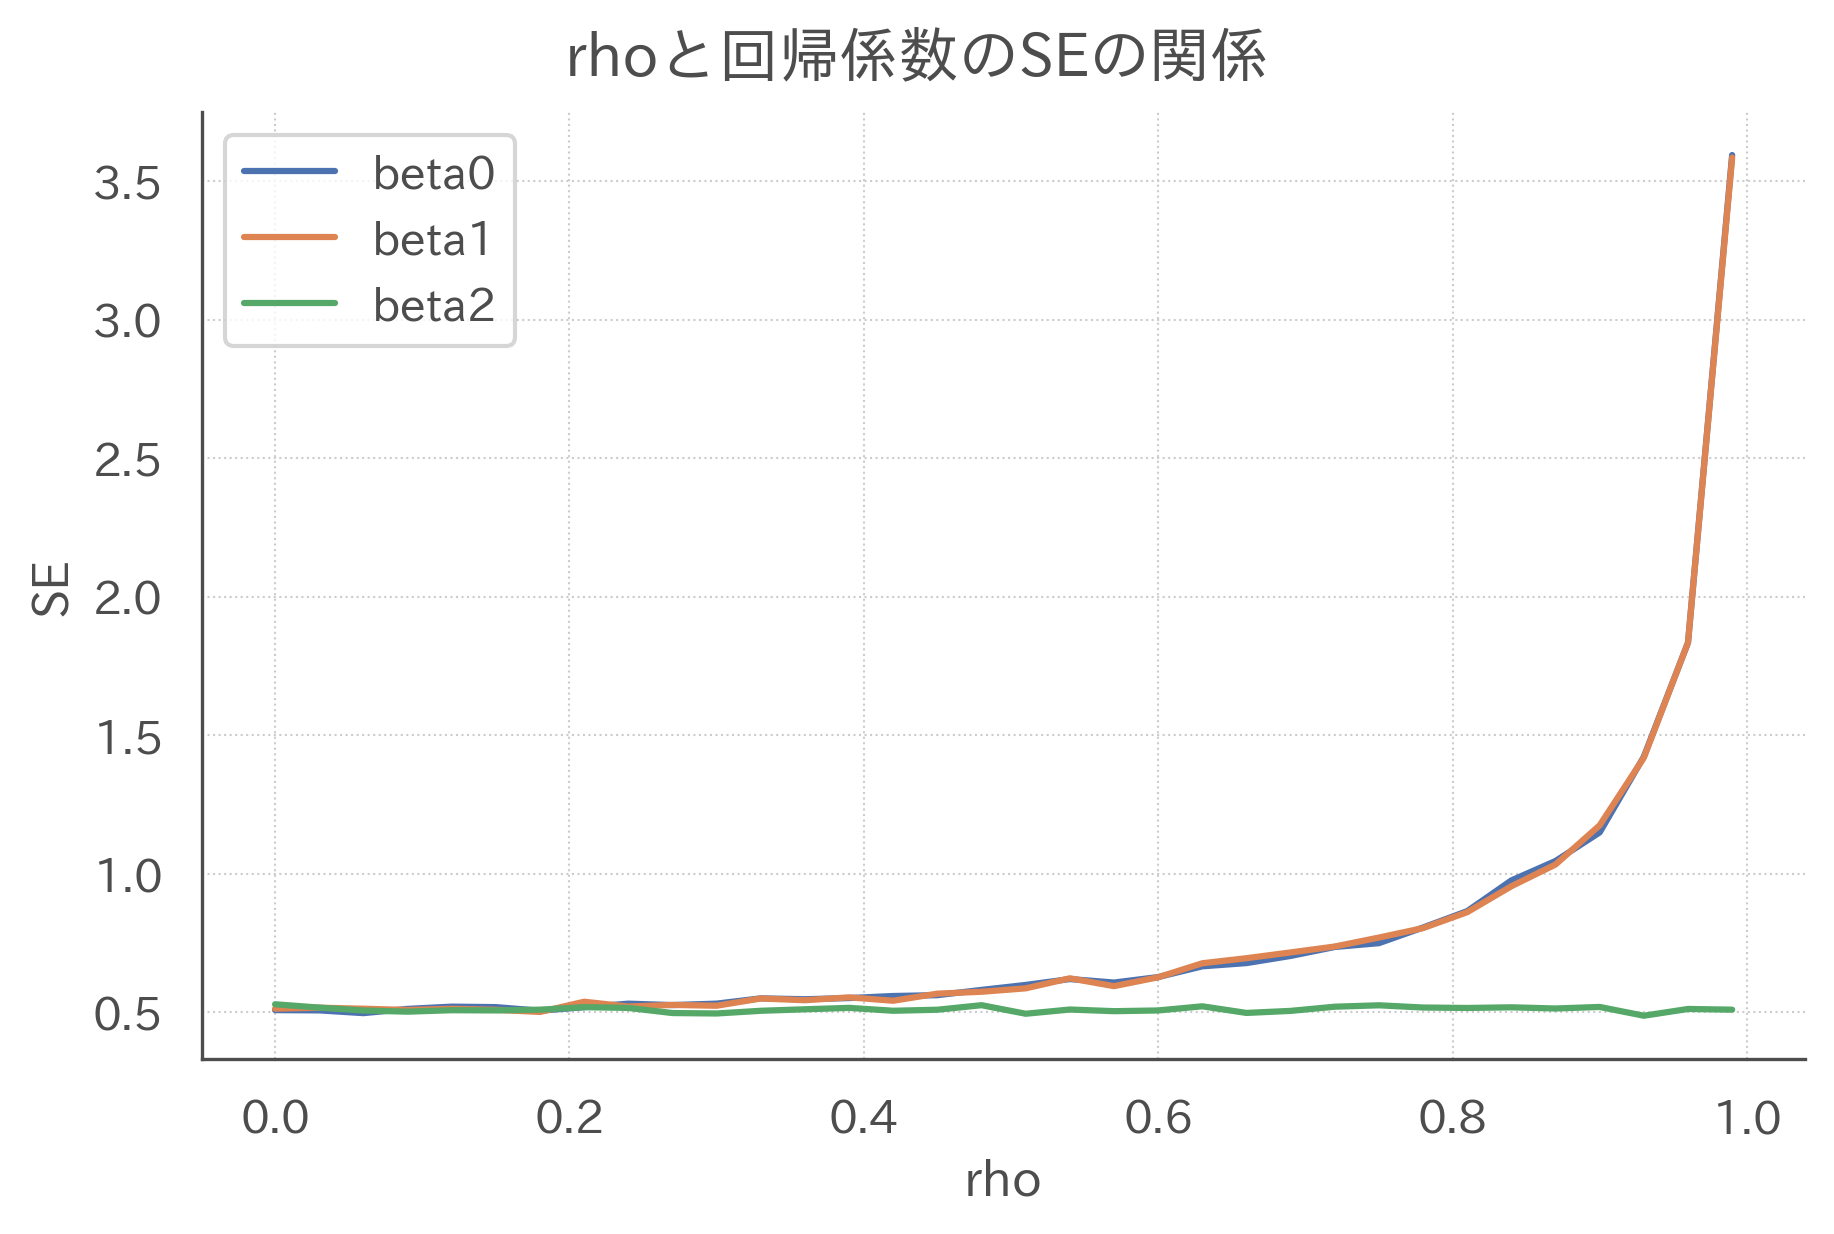

In [40]:
target_key = "rho"
target_values = np.arange(0, 1, 0.03).tolist()

s = Simulator(**base_params)
df = s.simulate(target_key, target_values, l2_lambda=0)
s.plot(df, target_key, "SE")

In [41]:
target_key = "n_samples"
target_values = np.arange(100, 1001, 100).tolist()

s = Simulator(**base_params)
df = s.simulate(target_key, target_values, l2_lambda=0)
s.plot(df, target_key, "SE")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 100 is different from 200)

In [26]:
df.loc[:, df.columns.str.startswith("se")]

,se0,se1,se2
0,0.519146,0.518594,0.509841
1,0.508732,0.521137,0.506666
2,0.503396,0.511378,0.503681
3,0.529360,0.512386,0.524873
4,0.510403,0.522050,0.500078
5,0.504449,0.500634,0.520850
6,0.516806,0.538348,0.515721
7,0.524437,0.524347,0.512747
8,0.516888,0.523601,0.525456
9,0.530172,0.536017,0.518347


In [295]:
np.row_stack([np.eye(3)] * 1000).reshape(1000, 3, 3)

array([[[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       ...,

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]])

In [290]:
np.repeat(np.eye(3), repeats=10000, axis=0).reshape(10000, 3, 3)

array([[[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       ...,

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]])

In [244]:
(np.linalg.inv(np.transpose(X, axes=(0, 2, 1)) @ X) @ (np.transpose(X, axes=(0, 2, 1)) @ y.reshape(n_simulations, param[0], 1))).reshape(n_simulations, beta.shape[0])

ValueError: cannot reshape array of size 1000000 into shape (1000,500,1)

In [ ]:
I nX ( X ′ X ) −1X ′

In [226]:
n_simulations = 1000

n_samples = np.array([100, 200, 300, 400, 500])
rhos = np.arange(0, 1, 0.03)
sigma_es = np.array([1, 2, 3, 4, 5])
params = list(product(n_samples, rhos, sigma_es))

beta = np.array([1, 1, 1])
mean_hbeta = np.zeros((len(params), beta.shape[0]))
se_hbeta = np.zeros((len(params), beta.shape[0]))
for p, param in enumerate(params):
    X, y = generate_simulation_data(n_simulations=n_simulations, n_samples=param[0], rho=param[1], sigma_e=param[2], beta=beta)    
    hbetas = (np.linalg.inv(np.transpose(X, axes=(0, 2, 1)) @ X) @ (np.transpose(X, axes=(0, 2, 1)) @ y.reshape(n_simulations, param[0], 1))).reshape(n_simulations, beta.shape[0])
    mean_hbeta[p, :] = hbetas.mean(axis=0)
    se_hbeta[p, :] = hbetas.std(axis=0)

In [227]:
df = pd.DataFrame(params, columns=['n_samples', 'rho', 'sigma_e'])
df[['beta1', 'beta2', 'beta3']] = mean_hbeta
df[['se1', 'se2', 'se3']] = se_hbeta

<AxesSubplot:xlabel='n_samples', ylabel='se1'>

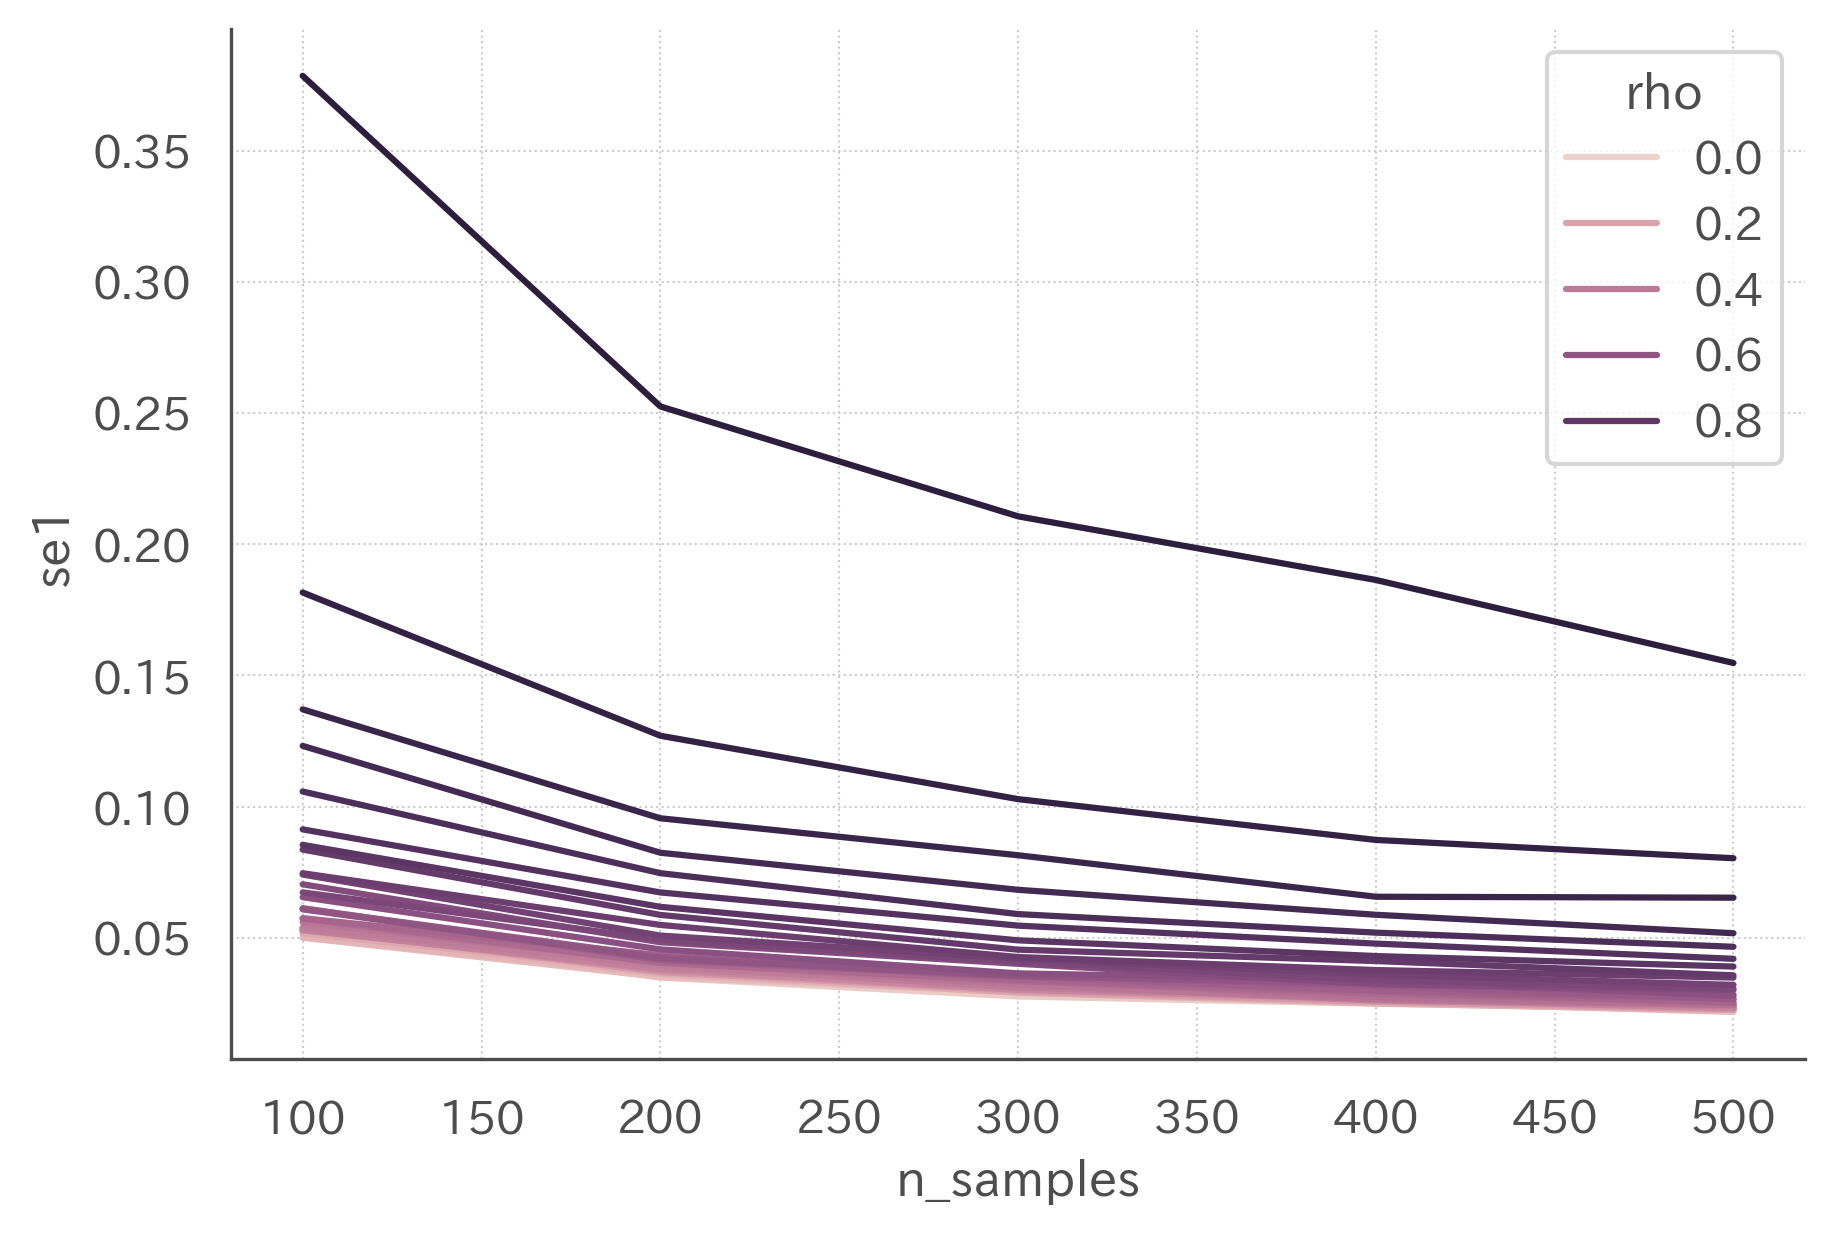

In [228]:
sns.lineplot('n_samples', 'se1', hue='rho', data=df[df.sigma_e == 1])

<AxesSubplot:xlabel='rho', ylabel='se1'>

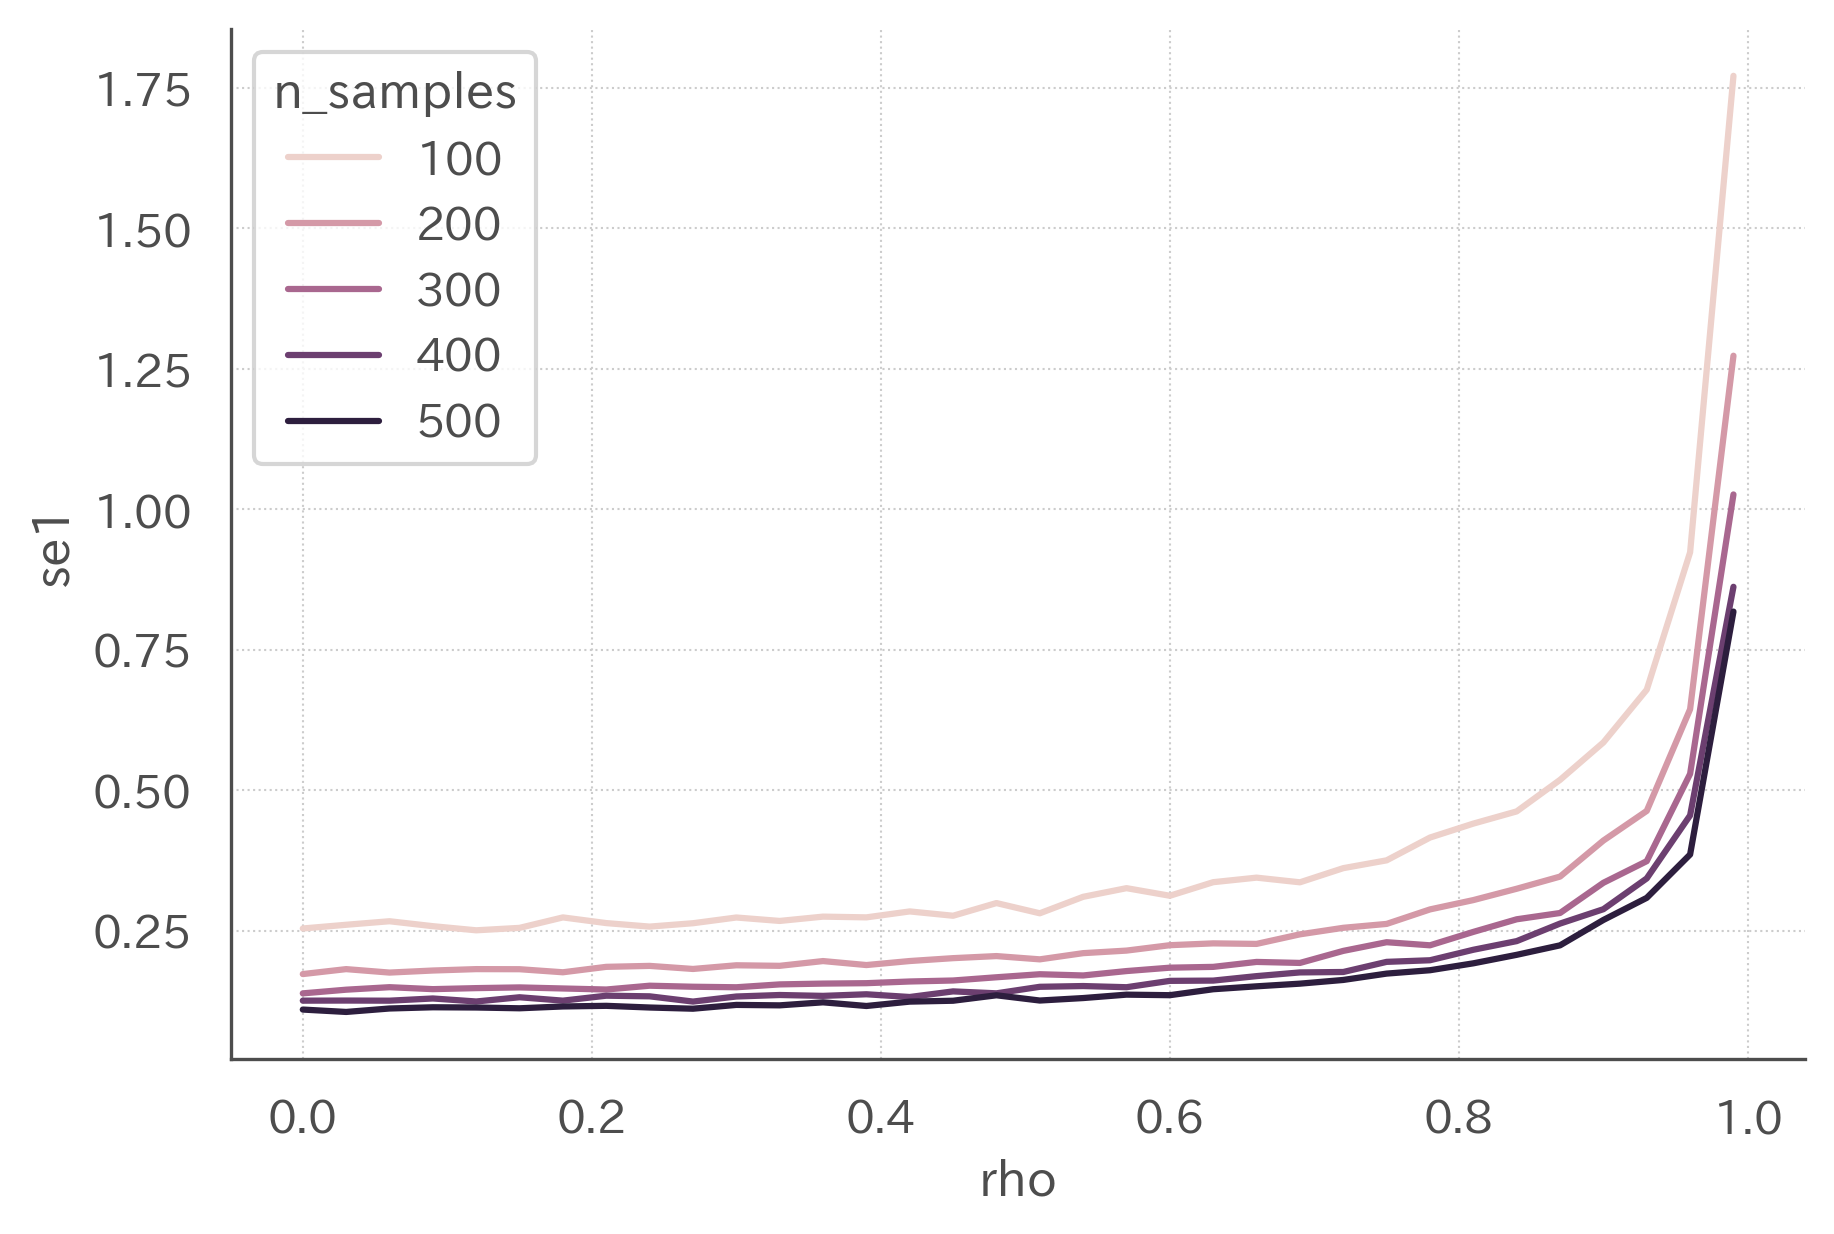

In [230]:
sns.lineplot('rho', 'se1', hue='n_samples', data=df[df.sigma_e == 5])

In [107]:
(X.reshape(10, 3, 100) @ X.reshape(3, 100 ,10))[0, :]

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (10,3,100)->(10,newaxis,newaxis) (3,100,10)->(3,newaxis,newaxis)  and requested shape (3,10)

In [103]:
(X[0, :].T @ X[0, :])

array([[ 475.55927236,  712.22270429,   48.48038645],
       [ 712.22270429, 1083.1899668 ,   72.56789452],
       [  48.48038645,   72.56789452, 1842.46463327]])

In [69]:
X, y = generate_simulation_data(n_simulations=10, n_samples=100, rho=rho, sigma_e=sigma_e, beta=beta)
hbetas = np.linalg.inv(X.T @ X) @ (X.T @ y)
se_hbeta = hbeta.std(axis=0)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 100 is different from 10)

In [48]:
np.arange(0, 1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [24]:
se_hbeta = np.sqrt(np.diag(np.linalg.inv(X.T @ X) * 1))
se_hbeta


array([0.11113133, 0.07357209])